In [1]:
# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scanpy as sc
from statsmodels.stats.multitest import fdrcorrection
import os
from pathlib import Path

# %% Set parameters
counts_file = 'results/counts/all_samples_counts.txt'
output_dir = Path('results/analysis')

os.chdir("/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Federica_RNA/")


output_dir.mkdir(parents=True, exist_ok=True)

## Load Data

In [2]:
def load_data(counts_file):
    """Load and process the count data"""
    # Read the counts file, skipping the first line (featureCounts info)
    counts = pd.read_csv(counts_file, sep='\t', skiprows=1)
    
    # Set gene names as index
    counts.set_index('Geneid', inplace=True)
    
    # Remove unnecessary columns from featureCounts
    cols_to_drop = ['Chr', 'Start', 'End', 'Strand', 'Length']
    counts = counts.drop(columns=[col for col in cols_to_drop if col in counts.columns])
    
    # Clean up sample names
    counts.columns = [os.path.basename(col).split('_Aligned')[0] for col in counts.columns]
    
    return counts

In [3]:
counts = load_data(counts_file)


In [4]:
counts.head()

,1,2,3,4,5,6,7,8,9,10,11,12
Geneid,,,,,,,,,,,,
ENSG00000290825.1,0,4,2,7,2,13,5,4,4,2,8,7
ENSG00000223972.6,1,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232.5,219,153,184,206,192,225,311,181,222,298,317,171
ENSG00000278267.1,9,2,5,10,6,3,7,5,6,6,8,8
ENSG00000243485.5,9,0,8,0,0,4,7,2,1,1,3,9


In [5]:
total_counts = counts.sum()
genes_detected = (counts > 0).sum()

In [6]:
print(total_counts)
print(genes_detected)

1     23072067
2     23156807
3     26003419
4     24355703
5     26544689
6     26901163
7     20815250
8     26622817
9     22411039
10    17077572
11    25504771
12    27564228
dtype: int64
1     50509
2     33727
3     35225
4     35632
5     33618
6     34285
7     35231
8     35867
9     35130
10    37550
11    36040
12    33979
dtype: int64


## Normalize Data

In [7]:
def normalize_counts(counts, method='cpm'):
    """
    Normalize count data
    
    Parameters:
    -----------
    method : str
        Normalization method ('cpm' or 'tmm')
    """
    if method == 'cpm':
        # CPM normalization
        norm_counts = counts.copy()
        norm_counts = (norm_counts * 1e6) / norm_counts.sum()
        return norm_counts
    else:
        raise ValueError(f"Normalization method '{method}' not implemented")

In [8]:
norm_counts = normalize_counts(counts)

## Filter Low Expression

In [9]:
def filter_low_expression(counts, norm_counts=None, min_counts=10, min_samples=2):
    """
    Filter out lowly expressed genes
    
    Parameters:
    -----------
    min_counts : int
        Minimum counts required
    min_samples : int
        Minimum number of samples that must meet min_counts
    """
    # Keep genes that have at least min_counts in at least min_samples samples
    mask = (counts >= min_counts).sum(axis=1) >= min_samples
    filtered_counts = counts.loc[mask]
    
    if norm_counts is not None:
        filtered_norm_counts = norm_counts.loc[mask]
        return filtered_counts, filtered_norm_counts
    return filtered_counts

In [10]:
counts, norm_counts = filter_low_expression(counts, norm_counts)

## Sample Statistics

In [17]:
def plot_sample_stats(total_counts, genes_detected, output_dir):
    """Generate basic sample statistics plots"""
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Total counts per sample
    sns.barplot(x=total_counts.index, y=total_counts.values, ax=ax1)
    ax1.set_title('Total Counts per Sample')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel('Total Counts')
    
    # Genes detected per sample
    sns.barplot(x=genes_detected.index, y=genes_detected.values, ax=ax2)
    ax2.set_title('Genes Detected per Sample')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylabel('Number of Genes')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'sample_stats.png')
    
    # Display in notebook
    plt.show()
    plt.close()

/tmp/ipykernel_1203896/1512396008.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipykernel_1203896/1512396008.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


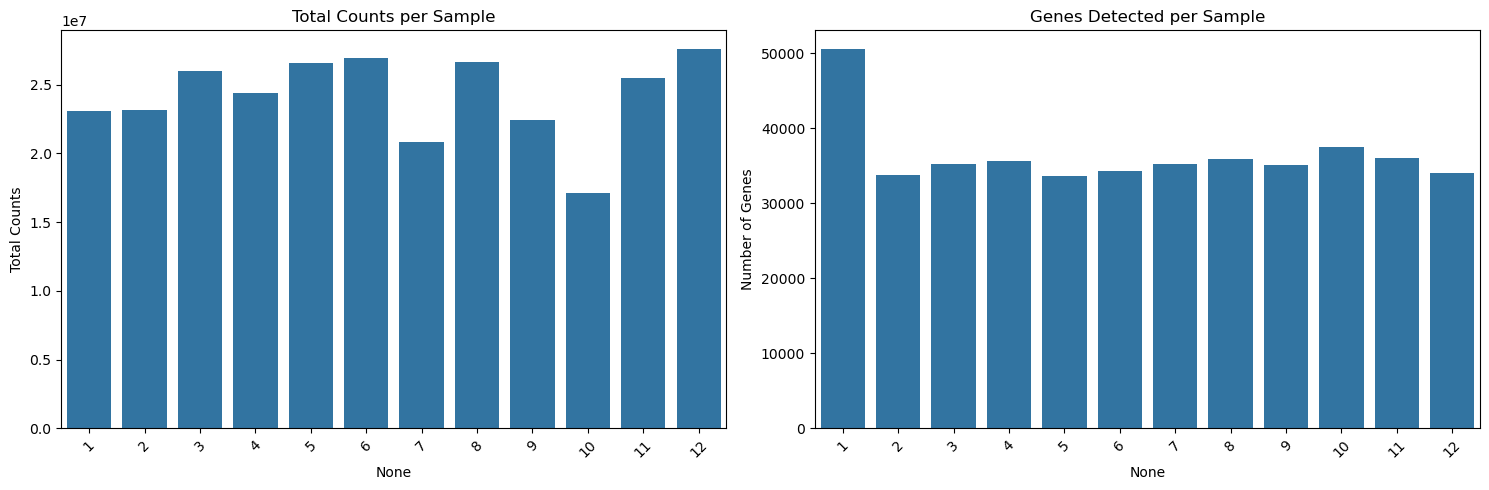

In [18]:
plot_sample_stats(total_counts, genes_detected, output_dir)


## Expression Distribution

In [19]:
def plot_expression_dist(counts, output_dir):
    """Plot expression distribution"""
    plt.figure(figsize=(10, 6))
    
    # Plot density of log2 transformed counts
    for col in counts.columns:
        sns.kdeplot(data=np.log2(counts[col] + 1), label=col)
        
    plt.title('Expression Distribution')
    plt.xlabel('log2(counts + 1)')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(output_dir / 'expression_dist.png')
    
    # Display in notebook
    plt.show()
    plt.close()

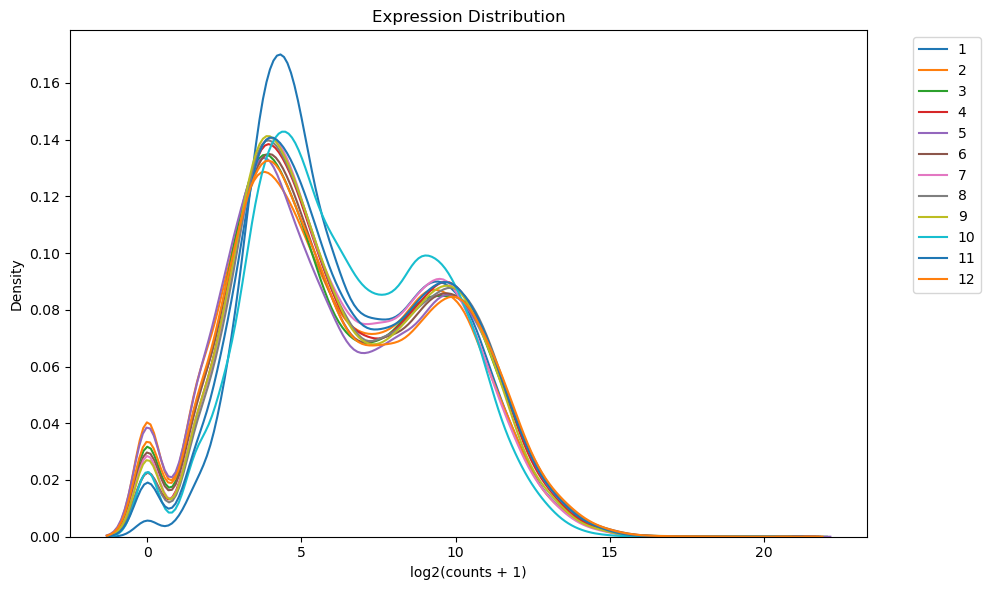

In [20]:
plot_expression_dist(counts, output_dir)

## PCA

In [23]:
def plot_pca(data, output_dir):
    """Perform and plot PCA"""
    # Log transform
    data = np.log2(data + 1)
    
    # Perform PCA using sklearn instead of scanpy
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data.T.values)
    variance_ratio = pca.explained_variance_ratio_
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    
    # Add sample labels
    for i, sample in enumerate(data.columns):
        plt.annotate(sample, (pca_result[i, 0], pca_result[i, 1]))
        
    plt.xlabel(f'PC1 ({variance_ratio[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({variance_ratio[1]:.1%} variance)')
    plt.title('PCA Plot')
    plt.tight_layout()
    plt.savefig(output_dir / 'pca_plot.png')
    
    # Display in notebook
    plt.show()
    plt.close()


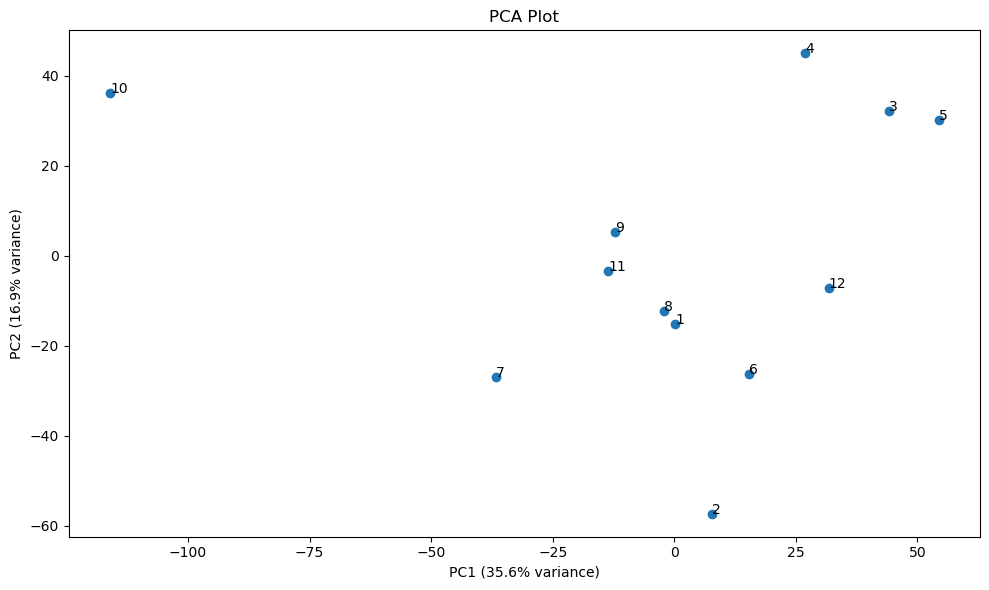

In [24]:
plot_pca(norm_counts, output_dir)

In [25]:
def plot_improved_pca(counts, norm_counts, output_dir, metadata=None, group_col=None):
    """
    Perform and plot enhanced PCA visualization
    
    Parameters:
    -----------
    counts : pandas DataFrame
        Raw count data
    norm_counts : pandas DataFrame
        Normalized count data
    output_dir : Path object
        Output directory for plots
    metadata : pandas DataFrame, optional
        Sample metadata with sample IDs as index
    group_col : str, optional
        Column in metadata to use for grouping
    """
    # Log transform
    log_data = np.log2(norm_counts + 1)
    
    # Perform PCA using sklearn
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Standardize features (important for PCA)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_data.T.values)
    
    # Calculate number of components (minimum of samples - 1 or 10)
    n_components = min(10, min(log_data.shape[1] - 1, log_data.shape[0]))
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    variance_ratio = pca.explained_variance_ratio_
    
    # Create figure with subplots (PCA plot and scree plot)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot PCA with proper grouping and colors
    if metadata is not None and group_col is not None:
        # Ensure samples match between data and metadata
        common_samples = list(set(norm_counts.columns) & set(metadata.index))
        if len(common_samples) != len(norm_counts.columns):
            print(f"Warning: Only {len(common_samples)} of {len(norm_counts.columns)} samples found in metadata")
        
        # Get sample indices and group information
        sample_indices = [list(norm_counts.columns).index(s) for s in common_samples]
        groups = metadata.loc[common_samples, group_col]
        unique_groups = groups.unique()
        
        # Generate color palette
        colors = sns.color_palette("Set2", len(unique_groups))
        color_map = dict(zip(unique_groups, colors))
        
        # Plot each group separately
        for group in unique_groups:
            group_samples = [i for i, s in enumerate(common_samples) if metadata.loc[s, group_col] == group]
            group_indices = [sample_indices[i] for i in group_samples]
            
            ax1.scatter(
                pca_result[group_indices, 0], 
                pca_result[group_indices, 1],
                label=group,
                s=80,
                alpha=0.8
            )
        
        # Add a legend
        ax1.legend(title=group_col)
    else:
        # Single color if no grouping provided
        scatter = ax1.scatter(
            pca_result[:, 0], 
            pca_result[:, 1],
            s=80,
            alpha=0.8
        )
    
    # Add sample labels
    for i, sample in enumerate(norm_counts.columns):
        ax1.annotate(
            sample, 
            (pca_result[i, 0], pca_result[i, 1]),
            fontsize=9,
            ha='center',
            va='center',
            xytext=(0, 7),
            textcoords='offset points'
        )
    
    # Add axis labels and title
    ax1.set_xlabel(f'PC1 ({variance_ratio[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({variance_ratio[1]:.1%} variance)')
    ax1.set_title('PCA Plot')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Add scree plot (variance explained)
    bars = ax2.bar(
        range(1, len(variance_ratio) + 1), 
        variance_ratio, 
        alpha=0.7,
        color='steelblue'
    )
    ax2.plot(
        range(1, len(variance_ratio) + 1), 
        np.cumsum(variance_ratio), 
        'ro-', 
        alpha=0.8
    )
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.annotate(
            f'{height:.1%}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=8
        )
    
    # Add cumulative labels
    cum_var = np.cumsum(variance_ratio)
    for i, cv in enumerate(cum_var):
        ax2.annotate(
            f'{cv:.1%}',
            xy=(i + 1, cv),
            xytext=(0, -15),
            textcoords="offset points",
            ha='center',
            va='bottom',
            color='darkred',
            fontsize=8
        )
    
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Proportion of Variance Explained')
    ax2.set_title('Scree Plot')
    ax2.set_xticks(range(1, len(variance_ratio) + 1))
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'enhanced_pca_plot.png', dpi=300)
    plt.show()
    plt.close()
    
    # Optional: Plot loading factors for top genes
    plt.figure(figsize=(12, 8))
    loading_scores = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=norm_counts.index
    )
    
    # Get top genes contributing to PC1 and PC2
    num_top_genes = 20
    pc1_loadings = loading_scores['PC1'].abs().sort_values(ascending=False)
    pc2_loadings = loading_scores['PC2'].abs().sort_values(ascending=False)
    
    top_genes = set(pc1_loadings.head(num_top_genes).index) | set(pc2_loadings.head(num_top_genes).index)
    top_genes = list(top_genes)[:30]  # Limit to max 30 genes for clarity
    
    # Create loading plot
    sns.heatmap(
        loading_scores.loc[top_genes, ['PC1', 'PC2']],
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0
    )
    plt.title('PCA Loading Factors for Top Genes')
    plt.tight_layout()
    plt.savefig(output_dir / 'pca_loadings.png', dpi=300)
    plt.close()
    
    return {
        'pca_obj': pca,
        'pca_result': pca_result,
        'loadings': loading_scores,
        'variance_ratio': variance_ratio
    }

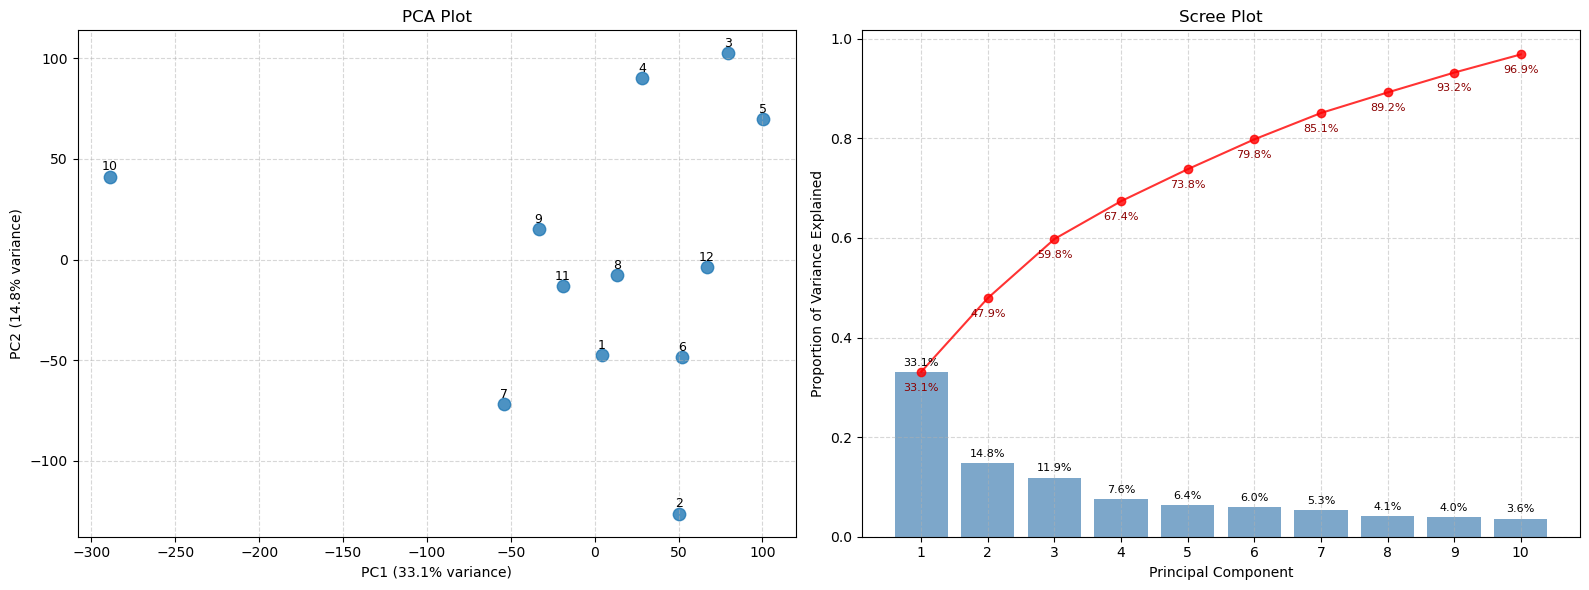

In [26]:
pca_results = plot_improved_pca(
    counts=counts,
    norm_counts=norm_counts,
    output_dir=output_dir
    )

## Differentaial Expression

In [27]:
def run_differential_expression(norm_counts, group1, group2, output_dir, method='t-test'):
    """
    Perform differential expression analysis
    
    Parameters:
    -----------
    group1 : list
        List of sample names for group 1
    group2 : list
        List of sample names for group 2
    method : str
        Statistical method to use
    """
    results = []
    for gene in norm_counts.index:
        g1_expr = norm_counts.loc[gene, group1]
        g2_expr = norm_counts.loc[gene, group2]
        
        if method == 't-test':
            stat, pval = stats.ttest_ind(g1_expr, g2_expr)
            
            # Handle division by zero and log2(0) cases
            g1_mean = g1_expr.mean()
            g2_mean = g2_expr.mean()
            
            if g1_mean == 0 and g2_mean == 0:
                fc = 0  # Both are zero, log2FC = 0
            elif g2_mean == 0:
                fc = np.inf  # Infinite fold change
            elif g1_mean == 0:
                fc = -np.inf  # Negative infinite fold change
            else:
                fc = np.log2(g1_mean / g2_mean)
                
            results.append({
                'gene': gene,
                'log2FC': fc,
                'pvalue': pval,
                'stat': stat
            })
            
    # Create results DataFrame
    de_results = pd.DataFrame(results)
    de_results.set_index('gene', inplace=True)
    
    # Multiple testing correction
    de_results['padj'] = fdrcorrection(de_results['pvalue'])[1]
    
    # Sort by adjusted p-value
    de_results.sort_values('padj', inplace=True)
    
    # Save results
    de_results.to_csv(output_dir / 'differential_expression_results.csv')
    
    return de_results

In [ ]:
# Example groups - replace with actual sample groups
group1 = ['1', '2', '3']  # control samples
group2 = ['4', '5', '6']  # treatment samples

de_results = run_differential_expression(norm_counts, group1, group2, output_dir)


/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.log2(g1_expr.mean() / g2_expr.mean())
/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.log2(g1_expr.mean() / g2_expr.mean())
/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.log2(g1_expr.mean() / g2_expr.mean())
/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.log2(g1_expr.mean() / g2_expr.mean())
/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.log2(g1_expr.mean() / g2_expr.mean())
/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc = np.log2(g1_expr.mean() / g2_expr.mean())
/tmp/ipykernel_1203896/1393886143.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  fc 

## Volcano plot

In [ ]:
def plot_volcano(de_results, output_dir, fc_threshold=1, pval_threshold=0.05):
    """
    Create volcano plot from differential expression results
    
    Parameters:
    -----------
    fc_threshold : float
        Log2 fold change threshold
    pval_threshold : float
        Adjusted p-value threshold
    """
    plt.figure(figsize=(10, 8))
    
    # Plot all points
    plt.scatter(
        de_results['log2FC'],
        -np.log10(de_results['padj']),
        alpha=0.5
    )
    
    # Highlight significant points
    significant = (abs(de_results['log2FC']) > fc_threshold) & \
                 (de_results['padj'] < pval_threshold)
    
    plt.scatter(
        de_results.loc[significant, 'log2FC'],
        -np.log10(de_results.loc[significant, 'padj']),
        color='red',
        alpha=0.5
    )
    
    plt.axhline(-np.log10(pval_threshold), color='gray', linestyle='--')
    plt.axvline(-fc_threshold, color='gray', linestyle='--')
    plt.axvline(fc_threshold, color='gray', linestyle='--')
    
    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10 Adjusted p-value')
    plt.title('Volcano Plot')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'volcano_plot.png')
    plt.close()


In [ ]:
plot_volcano(de_results, output_dir)